In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import cv2
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset 
import matplotlib.pyplot as plt
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import glob

In [2]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

In [27]:
### Device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [28]:
### Hyperparameters
BATCH_SIZE = 32
learning_rate = 0.00001
EPOCHS = 10

In [29]:
### Transformations on data
train_trans = transforms.Compose((
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
))
test_trans = transforms.Compose((
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
))

In [30]:
train_path = './data/seg_train/seg_train/'
test_path = './data/seg_test/seg_test/'

In [31]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [32]:
print(train_count,test_count)

14034 3000


In [55]:
import os
classes = os.listdir(train_path)
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [34]:
train_ds = torchvision.datasets.ImageFolder(root=train_path, transform=train_trans)
test_ds = torchvision.datasets.ImageFolder(root=test_path, transform=test_trans)

In [35]:
trainLoader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
testLoader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

In [36]:
images,labels = next(iter(trainLoader))
images.shape
# labels.shape

torch.Size([32, 3, 150, 150])

In [34]:
def show_tranformed_images(ds):
    loader = DataLoader(ds, shuffle=True, batch_size=BATCH_SIZE)
    batch = next(iter(loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('Labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([1, 5, 0, 1, 1, 0, 5, 4, 1, 1, 2, 5, 4, 4, 5, 1, 4, 2, 4, 3, 4, 1, 1, 4,
        1, 2, 3, 0, 5, 3, 4, 2])


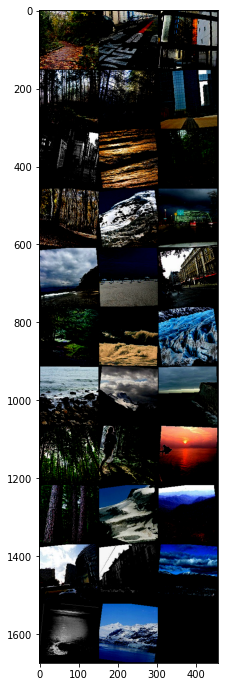

In [35]:
show_tranformed_images(train_ds)

In [69]:
### Model Architecture
class NNArch(nn.Module):
    def __init__(self):
        super(NNArch, self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (32,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (32,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (32,12,150,150)
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (32,12,75,75)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (32,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (32,20,75,75)
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (32,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (32,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (32,32,75,75)
        self.conv4=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        #Shape= (32,64,75,75)
        self.bn4=nn.BatchNorm2d(num_features=64)
        #Shape= (32,64,75,75)
        self.relu4=nn.ReLU()
        #Shape= (32,64,75,75)
        self.fc=nn.Linear(in_features=75 * 75 * 64,out_features=len(classes))
    def forward(self,x):
        output=self.conv1(x)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=self.conv4(output)
        output=self.bn4(output)
        output=self.relu4(output)
        #Above output will be in matrix form, with shape (32,64,75,75)
        output=output.view(-1,64*75*75)
        output=self.fc(output)
        return output
        
model = NNArch()

In [37]:
### Loss Func & Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
### Train Function
def trainOneEpoch(model, train_loader, epoch_index, device):
    train_loss = 0.
    train_accuracy = 0.
    model.to(device)   
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        _,prediction = torch.max(output.data,1)
        train_accuracy += (prediction==labels).sum().item()
        train_loss+= loss.cpu().data*images.size(0)
    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count
    return train_accuracy,train_loss            

In [46]:
def testAcc(model, test_loader, device):
    model.to(device)
    model.eval()
    test_accuracy = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _,prediction = torch.max(output.data,1)
            test_accuracy += (prediction==labels).sum().item()
            
    test_accuracy = test_accuracy/test_count
    return accuracy

In [49]:
print("The model will be running on", device, "device")
for epoch in range(EPOCHS):
    train_accuracy,train_loss = trainOneEpoch(model, trainLoader,epoch, device)
    test_accuracy = testAcc(model, testLoader, device)
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

The model will be running on cpu device
Epoch: 0 Train Loss: tensor(0.4917) Train Accuracy: 0.824355137523158 Test Accuracy: 76.53333333333333
Epoch: 1 Train Loss: tensor(0.4757) Train Accuracy: 0.8316232007980618 Test Accuracy: 76.53333333333333
Epoch: 2 Train Loss: tensor(0.4634) Train Accuracy: 0.8347584437793929 Test Accuracy: 76.53333333333333
Epoch: 3 Train Loss: tensor(0.4384) Train Accuracy: 0.8454467721248397 Test Accuracy: 76.53333333333333
Epoch: 4 Train Loss: tensor(0.4394) Train Accuracy: 0.844520450334901 Test Accuracy: 76.53333333333333
Epoch: 5 Train Loss: tensor(0.4195) Train Accuracy: 0.8532136240558643 Test Accuracy: 76.53333333333333
Epoch: 6 Train Loss: tensor(0.4038) Train Accuracy: 0.857702721960952 Test Accuracy: 76.53333333333333
Epoch: 7 Train Loss: tensor(0.3969) Train Accuracy: 0.8606954538976771 Test Accuracy: 76.53333333333333
Epoch: 8 Train Loss: tensor(0.3878) Train Accuracy: 0.8641869744905231 Test Accuracy: 76.53333333333333
Epoch: 9 Train Loss: tensor

In [3]:
model = torch.load('./intelClass.pth', map_location=torch.device('cpu'))

In [7]:
np_model = np.array(model)

In [12]:
from PIL import Image

In [86]:
img = Image.open('./data/seg_pred/seg_pred/458.jpg')

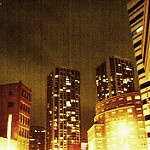

In [87]:
img

In [18]:
img_arr = np.asarray(img)

In [20]:
img_arr.shape

(150, 150, 3)

In [70]:
### Prediction on single image
def prediction(image,model):
    checkpoint = torch.load('./intelClass.pth', map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint)
    train_trans = transforms.Compose((
        transforms.Resize((150,150)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ))
    input_img = train_trans(image)
    input_img = input_img.view(1,3,150,150)
    output = model(input_img)
    predictions = int(torch.max(output.data, 1)[1].numpy())
    return predictions

In [71]:
model = NNArch()

In [88]:
prediction(img,model)

4

In [89]:
classes[2]

'glacier'